<a href="https://colab.research.google.com/github/Gopi-Vamsi-Penaganti/Malaria_Detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing packages**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.callbacks import Callback

# **DATA PREPARATION**

In [ ]:
# LOAD DATASET
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteHZJBCM/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# SPLIT DATASET 
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))


  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = test_dataset.take(int(TEST_RATIO*DATASET_SIZE))

  print(f'TOTAL :{len(dataset)} \nTRAIN :{len(train_dataset)} \nVAL : {len(val_dataset)} \nTEST :{len(test_dataset)}')
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

TOTAL :27558 
TRAIN :22046 
VAL : 2755 
TEST :2755


# **DATA VISUALIZATION**

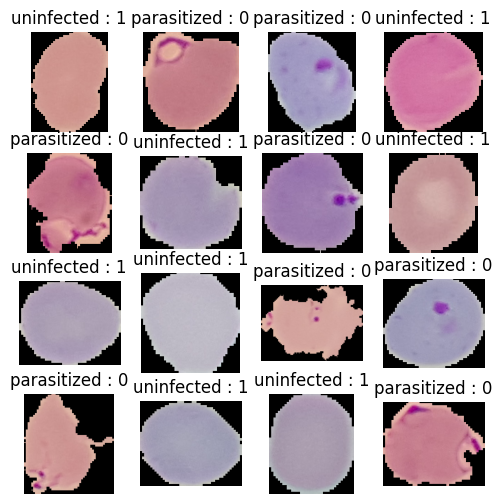

In [ ]:
plt.figure(figsize = (6,6))
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  class_name = dataset_info.features['label'].int2str(label)
  plt.title(f'{class_name} : {label}')
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(label)

'parasitized'

# **DATA PREPROCESSING**

In [ ]:
# Resize to (224,224)
# Rescale to 0-1 normalizing by *1/255

IM_SIZE = 224
def resizing_rescaling(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255,label

In [ ]:
train_dataset = train_dataset.map(resizing_rescaling)
val_dataset = val_dataset.map(resizing_rescaling)
test_dataset = test_dataset.map(resizing_rescaling)

In [ ]:
for image,label in train_dataset.take(1):
  img = np.array(image)
  print(f'SHAPE: {img.shape}')
  print(f'MAX : {img.max()} \nMIN : {img.min()}')

SHAPE: (224, 224, 3)
MAX : 0.7877451181411743 
MIN : 0.0


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Model Callbacks**

CSV_logger

In [ ]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'logs.csv', separator=',', append=False
)

Early Stoppings

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,
                            mode='auto',baseline=None,restore_best_weights=False)

**Tensorboard**

In [ ]:
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(
    log_dir='logs',)

In [ ]:
callbacks = [csv_callback,es_callback,tensorboard_callbacks]

# **Model Creation and Training**

In [ ]:
inputs = Input(shape=(224,224,3))

x = Conv2D(filters=6,kernel_size=5,strides=1,padding='valid',activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)

x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs,outputs,name='First_Model')
model.summary()


Model: "First_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Batc  (None, 106, 106, 16)     

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset,epochs=20,verbose=1,callbacks=callbacks)

Epoch 1/20
689/689 [==============================] - 55s 72ms/step - loss: 0.3043 - tp: 9979.0000 - fp: 1634.0000 - tn: 9390.0000 - fn: 1043.0000 - accuracy: 0.8786 - precision: 0.8593 - recall: 0.9054 - auc: 0.9407 - val_loss: 0.2794 - val_tp: 1338.0000 - val_fp: 187.0000 - val_tn: 1180.0000 - val_fn: 50.0000 - val_accuracy: 0.9140 - val_precision: 0.8774 - val_recall: 0.9640 - val_auc: 0.9738
Epoch 2/20
689/689 [==============================] - 49s 71ms/step - loss: 0.2070 - tp: 10344.0000 - fp: 884.0000 - tn: 10136.0000 - fn: 682.0000 - accuracy: 0.9290 - precision: 0.9213 - recall: 0.9381 - auc: 0.9697 - val_loss: 0.3377 - val_tp: 1229.0000 - val_fp: 65.0000 - val_tn: 1295.0000 - val_fn: 166.0000 - val_accuracy: 0.9162 - val_precision: 0.9498 - val_recall: 0.8810 - val_auc: 0.9726
Epoch 3/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1892 - tp: 10455.0000 - fp: 838.0000 - tn: 10182.0000 - fn: 571.0000 - accuracy: 0.9361 - precision: 0.9258 - recall: 0.9482

In [ ]:
history.history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])

**Visualizations**

Using Matplotlib

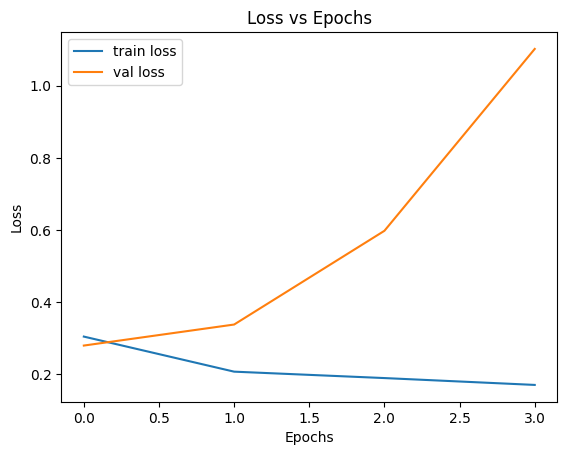

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss','val loss'])
plt.title('Loss vs Epochs')
plt.show()

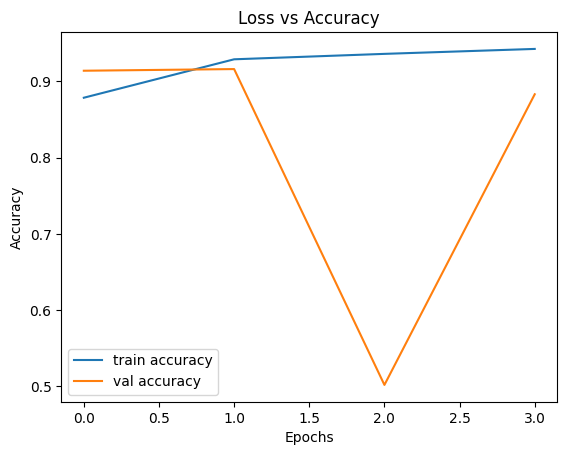

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train accuracy','val accuracy'])
plt.title('Loss vs Accuracy')
plt.show()

**Model Evaluation**

In [ ]:
test_dataset=test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

2755/2755 [==============================] - 26s 5ms/step - loss: 1.1215 - tp: 1343.0000 - fp: 298.0000 - tn: 1092.0000 - fn: 22.0000 - accuracy: 0.8838 - precision: 0.8184 - recall: 0.9839 - auc: 0.9195


[1.1215461492538452,
 1343.0,
 298.0,
 1092.0,
 22.0,
 0.8838475346565247,
 0.818403422832489,
 0.9838827848434448,
 0.9195030331611633]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not( model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 21ms/step


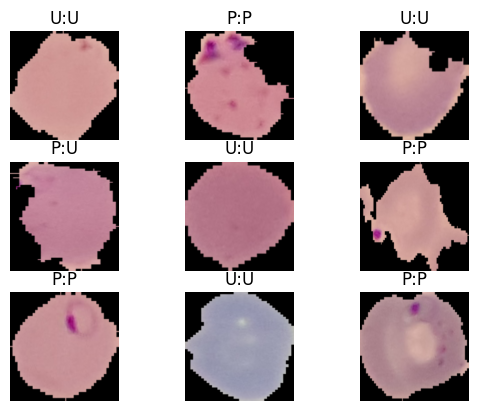

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+':'+str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

# **Load and Save models**

In [ ]:
# Save Model (CONFIG + WEIGHTS)
model.save('First_Model')

In [ ]:
model = tf.keras.models.load_model('/content/First_Model')
model.summary()

Model: "First_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Batc  (None, 106, 106, 16)     

In [ ]:
model.evaluate(test_dataset.take(1))

1/1 [==============================] - 12s 12s/step - loss: 7.0134e-09 - tp: 1.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00


[7.013394753840885e-09, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]

In [ ]:
# Light weight version hdf5 (CONFIG + WEIGHTS)
model.save('FIRST_MODEL.hdf5')

In [ ]:
model = tf.keras.models.load_model('/content/FIRST_MODEL.hdf5')

In [ ]:
model.summary()

Model: "First_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Batc  (None, 106, 106, 16)     

In [ ]:
# ONLY WEIGHTS

model.save_weights('Weight/lenet_weights')

In [ ]:
model_weights = model.load_weights('Weight/lenet_weights')

# **Model Subclass**

In [ ]:
# class FeatureExtractor(Layer):
#   def __init__(self, filter, kernal_size, strides, padding, activation, pool_size):
#     super(FeatureExtractor,self).__init__()
#     self.conv_1 = Conv2D(filters=filter,kernel_size=kernal_size, strides=strides, padding=padding,activation=activation)
#     self.batch_1 = BatchNormalization()
#     self.pool_1 =  MaxPool2D(pool_size= pool_size,strides=strides*2)
#     self.conv_2 = Conv2D(filters=2*filter,kernel_size=kernal_size, strides=strides, padding=padding,activation=activation)
#     self.batch_2 = BatchNormalization()
#     self.pool_2 =  MaxPool2D(pool_size= pool_size,strides=strides*2)

#   def call(self,x,training=True):
#     x = self.conv_1(x)
#     x = self.batch_1(x)
#     x = self.pool_1(x)

#     x = self.conv_2(x)
#     x = self.batch_2(x)
#     x = self.pool_2(x)
#     return x
# feature_sub_classed = FeatureExtractor(filter=8, kernal_size=3, strides=1, padding='valid', activation='relu', pool_size=2)

In [ ]:
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

# x = feature_sub_classed(func_input)

# x = Flatten()(x)

# x = Dense(100, activation = "relu")(x)
# x = BatchNormalization()(x)

# x = Dense(10, activation = "relu")(x)
# x = BatchNormalization()(x)

# func_output = Dense(1, activation = "sigmoid")(x)

# lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
# lenet_model_func.summary()

# **Evaluating Classification Models**

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y[0])
  inp.append(x.reshape(224,224,3))


In [ ]:
preds = model.predict(np.array(inp)).reshape(-1)


87/87 [==============================] - 1s 15ms/step


In [ ]:
threshold = 0.5
cm = confusion_matrix(labels,preds>threshold)
print(cm)

[[1089  301]
 [  22 1343]]


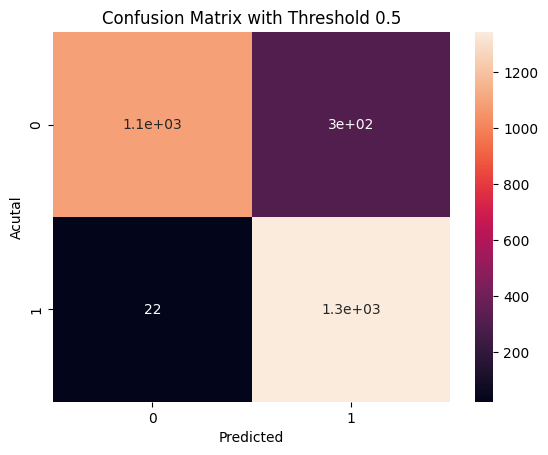

In [ ]:
#plot cm
sns.heatmap(cm,annot=True)
plt.title(f'Confusion Matrix with Threshold {threshold}')
plt.ylabel('Acutal')
plt.xlabel('Predicted')
plt.show()

**ROC PLots**

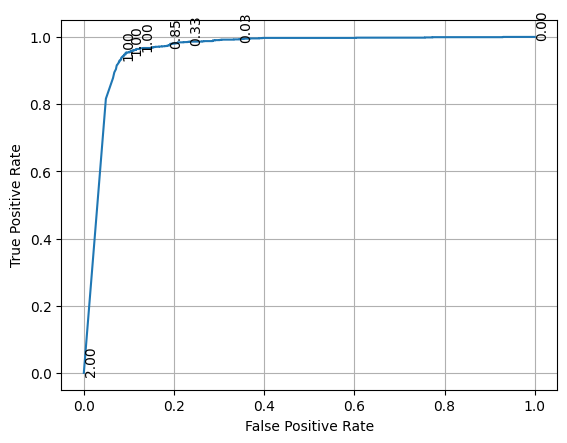

In [ ]:
fp, tp, threshold = roc_curve(labels,preds,drop_intermediate=True)
plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.grid()
skip=20
for i in range(0,len(threshold),skip):
  plt.text(fp[i],tp[i],"%.2f" %threshold[i], rotation=90)
plt.show()

In [ ]:
threshold = [x/10 for x in range(0,11,1)]
for th in threshold:
  cm = confusion_matrix(labels,preds>th)
  print(f'{th}-->{cm[0][1]}')

0.0-->1390
0.1-->381
0.2-->345
0.3-->325
0.4-->312
0.5-->301
0.6-->290
0.7-->286
0.8-->268
0.9-->250
1.0-->0


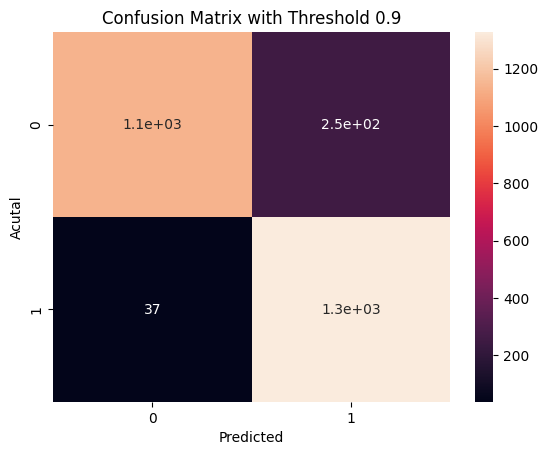

In [ ]:
#plot cm
threshold = 0.9
cm = confusion_matrix(labels,preds>threshold)
sns.heatmap(cm,annot=True)
plt.title(f'Confusion Matrix with Threshold {threshold}')
plt.ylabel('Acutal')
plt.xlabel('Predicted')
plt.show()